In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier

## Load and preprocess data 

In [75]:
df_train = pd.read_csv('train.csv', index_col=0)
df_test = pd.read_csv('test.csv', index_col=0)

In [56]:
# identify and replace missing values
print(df_train.isnull().sum())
print(df_test.isnull().sum())

print(df_train['opened_position_qty '].mean())
print(df_train['opened_position_qty '].median())

print(df_train['closed_position_qty'].mean())
print(df_train['closed_position_qty'].median())

# replace missing values with median (less sensitive to outliers)
df_train['opened_position_qty '].fillna(df_train['opened_position_qty '].median(),inplace=True)
df_test['opened_position_qty '].fillna(df_train['opened_position_qty '].median(),inplace=True)
df_train['closed_position_qty'].fillna(df_train['closed_position_qty'].median(),inplace=True)
df_test['closed_position_qty'].fillna(df_train['closed_position_qty'].median(), inplace=True)

last_price                   0
mid                          0
opened_position_qty     172460
closed_position_qty     172460
transacted_qty               0
d_open_interest              0
bid1                         0
bid2                         0
bid3                         0
bid4                         0
bid5                         0
ask1                         0
ask2                         0
ask3                         0
ask4                         0
ask5                         0
bid1vol                      0
bid2vol                      0
bid3vol                      0
bid4vol                      0
bid5vol                      0
ask1vol                      0
ask2vol                      0
ask3vol                      0
ask4vol                      0
ask5vol                      0
y                            0
dtype: int64
last_price                  0
mid                         0
opened_position_qty     53656
closed_position_qty     53656
transacted_qty              0


In [76]:
df_train = df_train.drop('opened_position_qty ', axis=1)
df_test = df_test.drop('opened_position_qty ', axis=1)
df_train = df_train.drop('closed_position_qty', axis=1) 
df_test = df_test.drop('closed_position_qty', axis=1)


In [77]:
# Normalize data
from sklearn import preprocessing

x_train = df_train[df_train.columns[:24]]
y_train = df_train['y']
x_test = df_test

# Normalize training data by subtracting mean and scaling to unit variance
std_scale = preprocessing.StandardScaler().fit(x_train)
x_train_norm = std_scale.transform(x_train)
x_train = pd.DataFrame(x_train_norm, index=x_train.index, columns=x_train.columns)

# Normalize testing data by using mean and SD of training set
x_test_norm = std_scale.transform(x_test)
x_test = pd.DataFrame(x_test_norm, index=x_test.index, columns=x_test.columns) 

In [78]:
# Split training and validation data 
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

## Build and train model

In [58]:
clf = RandomForestClassifier(criterion='gini', n_jobs=-1)
parameters = {
    "n_estimators":[16,32,64,100,250],
    "max_depth":[4,8,16,32,64,None]
    
}

In [59]:
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(clf,parameters,cv=5)
cv.fit(x_train, y_train)
train_pred = clf.predict(x_train)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('train auc: {}'.format(roc_auc))
y_pred = clf.predict(x_val)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('val auc: {}'.format(roc_auc))

KeyboardInterrupt: 

In [68]:
y_pred = clf.predict(x_val)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('val auc: {}'.format(roc_auc))

val auc: 0.994212555752104


In [79]:
from sklearn.metrics import roc_curve, auc
n_estimators = 64
max_depth=35

clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=35, criterion='gini', n_jobs=-1, oob_score=True)
clf.fit(x_train, y_train)
train_pred = clf.predict(x_train)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('train auc: {}'.format(roc_auc))
y_pred = clf.predict(x_val)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('val auc: {}'.format(roc_auc))
print(clf.oob_score_)

train auc: 0.9947489427621383
val auc: 0.576784123132707
0.6527967689658665


In [53]:
# tune some parameter

min_samples_leafs = [1,2,3,4,5]
train_results = []
test_results = []
for msl in min_samples_leafs:
   print(msl)
   clf = RandomForestClassifier(n_estimators=64, max_depth=35, min_samples_leaf=msl, n_jobs=-1)
   clf.fit(x_train, y_train)
   train_pred = clf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = clf.predict(x_val)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)


1
2
3
4
5


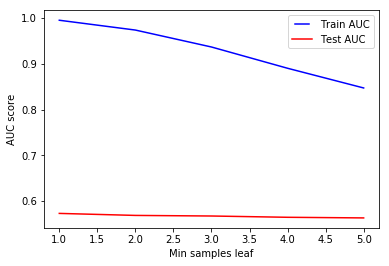

In [54]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Min samples leaf')
plt.savefig('min_samples_leafs')
plt.show()

In [33]:
# evaluate training classification accuracy and feature importance
training_accuracy = clf.score(x_train, y_train)
print(training_accuracy)
print(clf.feature_importances_)

0.9964617306458692
[0.04380894 0.04002972 0.01659711 0.0163494  0.02358494 0.02434179
 0.03429429 0.03322396 0.03320424 0.03383375 0.03486082 0.03450899
 0.03340845 0.03344581 0.0340356  0.03482751 0.04144936 0.04542063
 0.05090293 0.05186977 0.05225915 0.05820432 0.04367556 0.05032861
 0.05024588 0.05128846]


## Save results

In [64]:
df_test['Predicted'] = clf.predict_proba(x_test)[:,1]
df_test[['Predicted']].to_csv('submission_model6.csv')

In [74]:
clf.oob_score_

0.6516374624396503